# Reset variables and imports

```
pip install pandas

```

In [30]:
%reset -f
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
datasets = {
    "full_body": {
        "dicom_file": None,
        "dicom_folder": "./data/wetransfer_59320363_2024-05-23_1500/",
        "good_slice_indices": (3, 997),
        "output_folder": "data"
    }
}

# Choose dataset
dataset_name = "full_body"  # Change to "preop" to switch datasets

# Load selected dataset
dicom_folder = datasets[dataset_name]["dicom_folder"]
good_slice_indices = datasets[dataset_name]["good_slice_indices"]
output_folder = datasets[dataset_name]["output_folder"]

print(f"Using {dataset_name} dataset: {dicom_folder}")


Using full_body dataset: ./data/wetransfer_59320363_2024-05-23_1500/


### Investigating DICOM

In [32]:

slices = []
filename = sorted(os.listdir(dicom_folder))[0]  
filepath = os.path.join(dicom_folder, filename)
ds = pydicom.dcmread(filepath)


print(np.shape(ds.pixel_array))
print(ds.NumberOfFrames)


(16, 192, 192)
16


MRI machines work differently from CT scanners in how they acquire and store data. The (16, 192, 192) shape suggests that the MRI DICOM file contains a 3D volume as a single slice, rather than individual 2D slices like a CT scan. Here’s why:

- Multi-frame DICOMs: MRI machines often store multiple slices in a single file, whereas CT scans usually have one file per slice. The 16 in your shape likely represents 16 slices stored in one DICOM file.
- Different Image Encoding: MRI scans are not always stored as a simple sequence of axial slices. Instead, they can include multi-echo, multi-phase, or multi-slice acquisitions in a single DICOM file.
Different Scanning Technique: Unlike CT, which measures X-ray absorption, MRI reconstructs images based on proton resonance signals. This can result in different data structures, especially in cases of diffusion-weighted imaging (DWI), functional MRI (fMRI), or spectroscopy.

We have confirmed its a multi-frame DICOM with ``dicom_slices[0].NumberOfFrames``

# Create table of most interesting DICOM datasets

The most important difference is that to create our volume .nrrd datasets we no longer need multiple DICOM files. Each DICOM file is no a standalone dataset that can be converted to a volumetric .nrrd file. 

We will inspect each DICOM file and store information about it like the shape, name, number of slices in a table. This way we can process the most important ones later.

In [33]:
def load_dicom_metadata(dicom_folder):
    metadata = []  # List to store metadata dictionaries
    for filename in sorted(os.listdir(dicom_folder)):
        filepath = os.path.join(dicom_folder, filename)
        ds = pydicom.dcmread(filepath)
        
        # Skip non-image files
        if "PixelData" in ds:
            shape = ds.pixel_array.shape  # Get shape of the pixel array
            metadata.append({
                'filename': filename,
                'num_slices': shape[0],  # Assume shape[0] is the number of slices
                'shape': shape,
                'modality': ds.Modality if 'Modality' in ds else 'Unknown',
                'study_date': ds.StudyDate if 'StudyDate' in ds else 'Unknown'
            })
    
    # Create a DataFrame from the metadata
    df = pd.DataFrame(metadata)
    return df

# Load DICOM metadata into a DataFrame
dicom_metadata_df = load_dicom_metadata(dicom_folder)

# Sort by the number of slices in descending order and select the top N
top_n = 5  # Set the number of top datasets you want
top_datasets = dicom_metadata_df.sort_values(by='num_slices', ascending=False).head(top_n)

# Print the metadata of the top N datasets
top_datasets



,filename,num_slices,shape,modality,study_date
63,59321221,236,"(236, 192, 256)",MR,20230913
62,59321210,236,"(236, 192, 256)",MR,20230913
61,59321199,236,"(236, 192, 256)",MR,20230913
64,59321232,236,"(236, 192, 256)",MR,20230913
103,59321661,88,"(88, 264, 352)",MR,20230913


In [34]:
def load_dicom_data(dicom_folder, file_name):
    # Construct the file path using the folder and the given filename
    file_path = os.path.join(dicom_folder, file_name)
    
    # Read the DICOM file
    ds = pydicom.dcmread(file_path)
    
    # Ensure the file contains PixelData
    if "PixelData" in ds:
        # Convert the pixel data into a NumPy array
        return ds.pixel_array
    else:
        raise ValueError(f"File {file_name} does not contain pixel data.")

file_name = '59321199' # beste voor spieren
dicom_data = load_dicom_data(dicom_folder, file_name)
print(dicom_data.shape)


(236, 192, 256)


In [35]:
for file_name in top_datasets['filename']:
    dicom_data = load_dicom_data(dicom_folder, file_name)
    # Save the NumPy array
    output_path = os.path.join(output_folder, f"mri_{file_name}.npy")
    np.save(output_path, dicom_data)

    print(f"Saved {output_path}")


Saved data\mri_59321221.npy
Saved data\mri_59321210.npy
Saved data\mri_59321199.npy
Saved data\mri_59321232.npy
Saved data\mri_59321661.npy


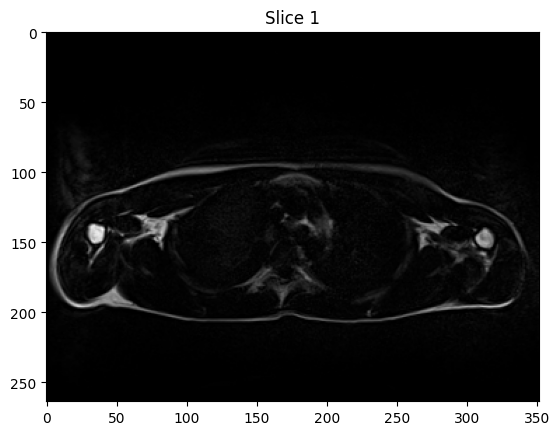

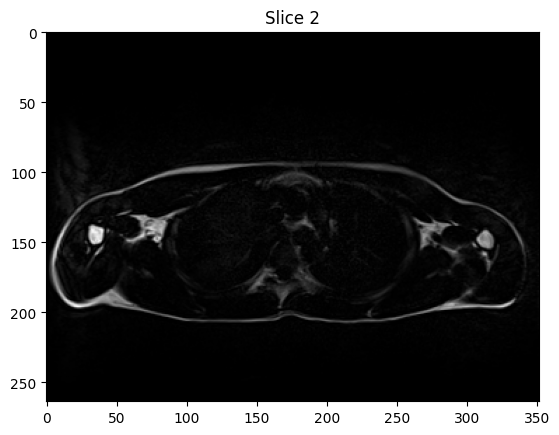

In [36]:
import matplotlib.pyplot as plt

slice_index = 0  

for i in range(dicom_data.shape[0]):  # Loop through each slice
    plt.imshow(dicom_data[i], cmap="gray")  # Display each slice in grayscale
    plt.title(f"Slice {i+1}")
    plt.show()
    if i > 0:
        break
